In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import seaborn as sns

In [6]:
def to_duration(df):
    """a function that converts the original data of one rat to start time, duration and id

    Args:
        df (pandas dataframe): the original data of one rat

    Returns:
        out_df (pandas dataframe): converted data
    """

    #if starts from zero, remove the first row
    if df.iloc[0]['movement']==0:
        df=df.drop(index=df.index[0],axis=0)
    #if ends in one, remove the last row
    if df.iloc[-1]['movement']==1:
        df=df.drop(index=df.index[-1],axis=0)
        
    #calculate durations and generate a time index
    time_index=df[df['movement']==1].index
    durations=df[df['movement']==0]['ms_from_start'].to_numpy()-df[df['movement']==1]['ms_from_start'].to_numpy()
    
    #generate an output dataframe
    out_df = pd.DataFrame(durations,index=time_index, columns=['duration_ms'])
    out_df['id']=df['id'].iloc[0]
    
    return out_df

In [7]:
#select paths
paths=glob.glob(r"C:\motion_data\*")

['C:\\Users\\marty\\Documents\\DATA\\tween_cbn_sleep\\motion_data\\20231109',
 'C:\\Users\\marty\\Documents\\DATA\\tween_cbn_sleep\\motion_data\\20231110',
 'C:\\Users\\marty\\Documents\\DATA\\tween_cbn_sleep\\motion_data\\20231111',
 'C:\\Users\\marty\\Documents\\DATA\\tween_cbn_sleep\\motion_data\\20231112']

In [8]:
#list for results
res_dfs=[]
#launch program for all recs
for path in paths:
    #read data, label correctly
    data=pd.read_csv(path,header=None,names=['time','id','ms_from_start','movement'])
    data=data.set_index(pd.to_datetime(data['time'])).drop('time',axis=1)
    #conversion of pin to rat id
    pin_to_id={2:21,4:23,5:24,6:25,7:26}
    data=data.replace({'id':pin_to_id})
    #split by rat and convert to start time+duration
    dfs_by_id=[]
    for rat in np.unique(data['id']):
        dfs_by_id.append(to_duration(data[data['id']==rat]))
    #integrate over time
    time_to_integrate='60min'

    for df in dfs_by_id:
        time_intervals=df.index.round(time_to_integrate).drop_duplicates()
        durations_in_time_intervals=[]
        for j in range(0, len(time_intervals)-1):
            durations_in_time_intervals.append(df['duration_ms'].loc[time_intervals[j]:time_intervals[j+1]].sum())
        #remove last element because it's empty
        time_intervals=time_intervals[0:-1]
        res_df=pd.DataFrame(durations_in_time_intervals, index=time_intervals, columns=['duration_ms'])
        res_df['hour']=df.index.round(time_to_integrate).drop_duplicates().strftime('%H').tolist()[0:-1]
        res_df['day']=df.index.round(time_to_integrate).drop_duplicates().strftime('%Y-%m-%d').tolist()[0:-1]
        res_df['id']=df['id'][0]
        res_dfs.append(res_df)
#join to a single df
res_df=pd.concat(res_dfs)

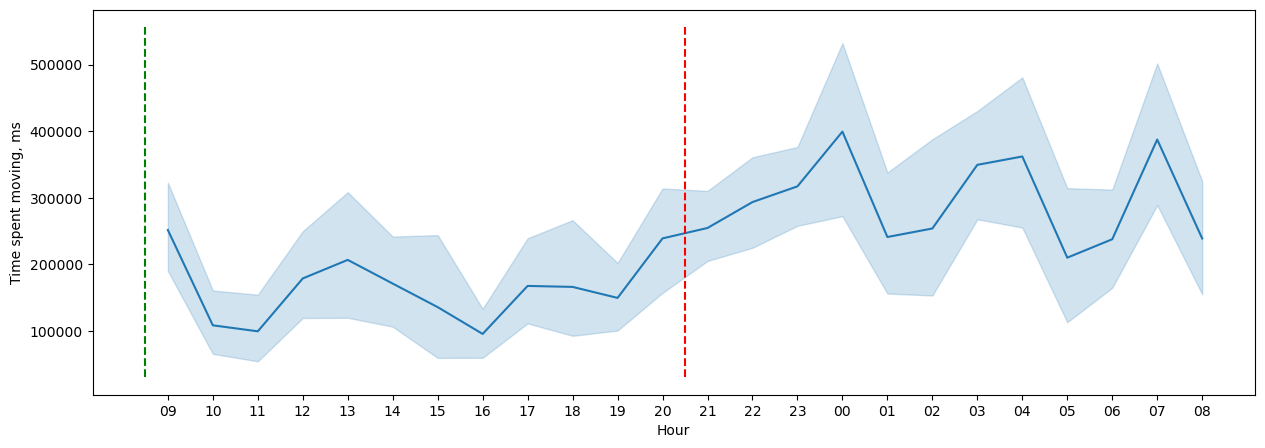

In [20]:
#plot to check - example
plt.figure(figsize=(15,5))
sns.lineplot(data=res_df,x='hour',y='duration_ms')
xmin, xmax, ymin, ymax=plt.axis()
plt.vlines(x=[11.5, -0.5],ymin=ymin,ymax=ymax, colors=['r','g'],linestyles='--')
plt.xlabel('Hour')
plt.ylabel('Time spent moving, ms')
plt.show()